# crypto_ml scratch note
Cryptocurrency machine learning project 
## Project assumptions:
### Must have:
- Connect to cryptocurrency exchange API (Binance API) and download data
- Save data to database 
- Periodic data update
- Data analysis and prepering.
- Create a machine learning model 
- Result presentation and adapting the application to the user 

### Nice have:
- Copmarsion of different ML models
- Adding new options for user

### Vision:
- Creating a trading bot
- Creating a model based on reinforcement learning


In [1]:
# pip install requests
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install sklearn

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
api_base_endpoint = "https://api.binance.com"
api_current_price = api_base_endpoint + "/api/v3/ticker/price"
api_historical_price = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=BTCUSDT&interval=1d"

In [3]:
r_current_price = requests.get(api_current_price)
r_historical_price = requests.get(api_historical_price)

In [4]:
current_price = pd.read_json(r_current_price.text)

In [5]:
current_price

,symbol,price
0,ETHBTC,0.049500
1,LTCBTC,0.004707
2,BNBBTC,0.010834
3,NEOBTC,0.001675
4,QTUMETH,0.005160
...,...,...
1423,SLPBUSD,0.313000
1424,SLPUSDT,0.312200
1425,TRXAUD,0.169400
1426,TRXEUR,0.108400


,Open,High,Low,Close,Volume
Open time,,,,,
2018-08-06,7024.19,7160.00,6821.00,6934.82,32760.191643
2018-08-07,6935.00,7150.46,6670.00,6720.06,45438.473501
2018-08-08,6720.63,6721.54,6123.00,6285.00,59550.536319
2018-08-09,6283.27,6622.81,6178.60,6529.79,51941.185111
2018-08-10,6529.79,6575.88,6026.39,6144.01,59034.974902
...,...,...,...,...,...
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015
2021-04-29,54846.23,55195.84,52330.94,53555.00,52486.019455


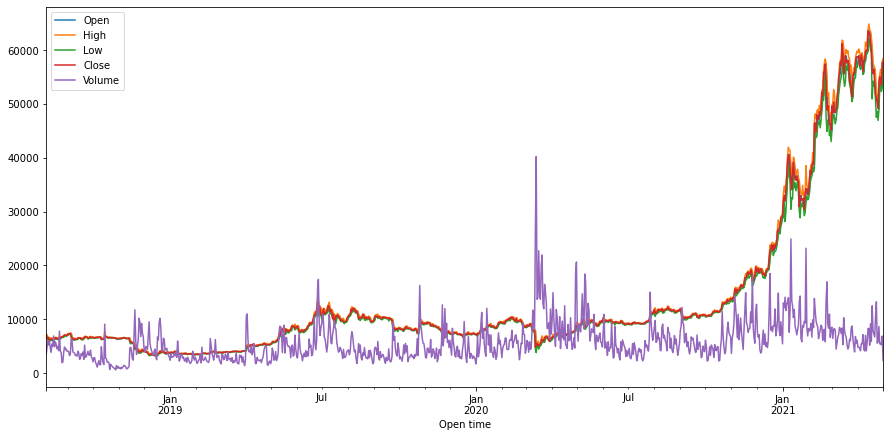

In [6]:
historical_price = pd.read_json(r_historical_price.text)

del_columns = historical_price.iloc[:,6:]
historical_price = historical_price.drop(del_columns, axis=1)
historical_price = historical_price.rename(columns={0:'Open time', 1:'Open', 2:'High', 3:'Low', 4:'Close', 5:'Volume'})
historical_price['Open time'] = pd.to_datetime(historical_price['Open time'], unit="ms")
historical_price = historical_price.set_index('Open time')

plot_price = historical_price.copy()
plot_price['Volume'] = plot_price['Volume']/10
plot_price.plot(figsize=(15,7))

historical_price

In [7]:
close_predict = historical_price.copy()

close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()
close_predict['next_day_close_price'] = close_predict['Close'].shift(-1)
close_predict = close_predict.dropna()

close_predict

,Open,High,Low,Close,Volume,close_3,close_9,next_day_close_price
Open time,,,,,,,,
2018-08-14,6248.25,6250.33,5880.00,6188.08,50186.745091,6247.586667,6398.754444,6267.16
2018-08-15,6188.08,6609.00,6172.11,6267.16,68806.687026,6233.863333,6324.570000,6311.75
2018-08-16,6265.27,6480.00,6205.60,6311.75,48515.254618,6255.663333,6279.202222,6584.49
2018-08-17,6316.00,6585.00,6285.40,6584.49,57851.610803,6387.800000,6312.478889,6387.96
2018-08-18,6579.04,6620.00,6288.00,6387.96,53742.322172,6428.066667,6296.720000,6477.53
...,...,...,...,...,...,...,...,...
2021-04-26,49066.76,54356.62,48753.44,54001.39,86310.802124,51038.666667,53103.097778,55011.97
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675,52693.376667,52976.648889,54846.22
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015,54619.860000,52889.213333,53555.00


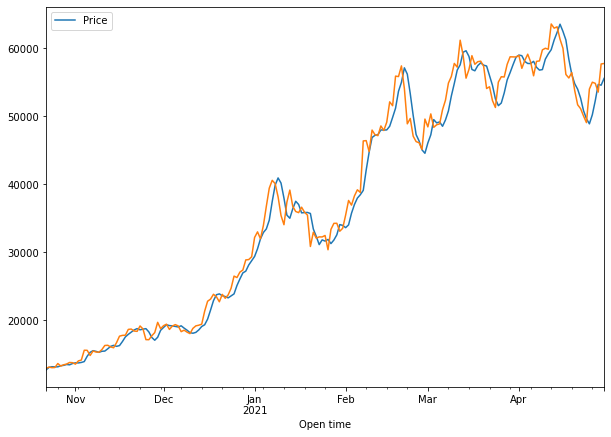

Predict score: 98.43
Crypto Price (y) = 1.23 * 3 Days Moving Average (x1) + -0.24 * 9 Days Moving Average (x2) + 71.73 (constant)


In [8]:
X = close_predict[['close_3', 'close_9']]

y = close_predict['next_day_close_price']

t = 0.8
t = int(t*len(historical_price))
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

model = LinearRegression()
model.fit(X_train, y_train)

predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])

predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.show()

score = model.score(X[t:], y[t:])*100
print(f"Predict score: {float(score.round(2))}" )

print(f"Crypto Price (y) = {model.coef_[0].round(2)} * 3 Days Moving Average (x1) \
+ {model.coef_[1].round(2)} * 9 Days Moving Average (x2) \
+ {model.intercept_.round(2)} (constant)")

In [9]:
close_predict = historical_price.copy()

close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()
close_predict = close_predict.dropna()

close_predict['predicted_crypto_price'] = model.predict(close_predict[['close_3', 'close_9']])

close_predict.tail()

,Open,High,Low,Close,Volume,close_3,close_9,predicted_crypto_price
Open time,,,,,,,,
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675,52693.376667,52976.648889,52290.312512
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015,54619.860000,52889.213333,54680.751134
2021-04-29,54846.23,55195.84,52330.94,53555.00,52486.019455,54471.063333,52570.324444,54573.548018
2021-04-30,53555.00,57963.00,53013.01,57694.27,68578.910045,55365.163333,53004.395556,55570.116054
2021-05-01,57697.25,58458.07,57116.16,57763.57,23213.310223,56337.613333,53679.130000,56605.834852


In [10]:
mean_predict = historical_price[['Open', 'High', 'Low', 'Close']].copy()

mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i].mean()
mean_predict['next_day_price'] = mean_predict['mean'].shift(-1)
mean_predict = mean_predict.dropna()

mean_predict


C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,next_day_price
Open time,,,,,,
2018-08-06,7024.19,7160.00,6821.00,6934.82,5588.002,5495.104
2018-08-07,6935.00,7150.46,6670.00,6720.06,5495.104,5170.034
2018-08-08,6720.63,6721.54,6123.00,6285.00,5170.034,5122.894
2018-08-09,6283.27,6622.81,6178.60,6529.79,5122.894,5055.214
2018-08-10,6529.79,6575.88,6026.39,6144.01,5055.214,4967.896
...,...,...,...,...,...,...
2021-04-26,49066.76,54356.62,48753.44,54001.39,41235.642,43539.070
2021-04-27,54001.38,55460.00,53222.00,55011.97,43539.070,44019.870
2021-04-28,55011.97,56428.00,53813.16,54846.22,44019.870,43185.602


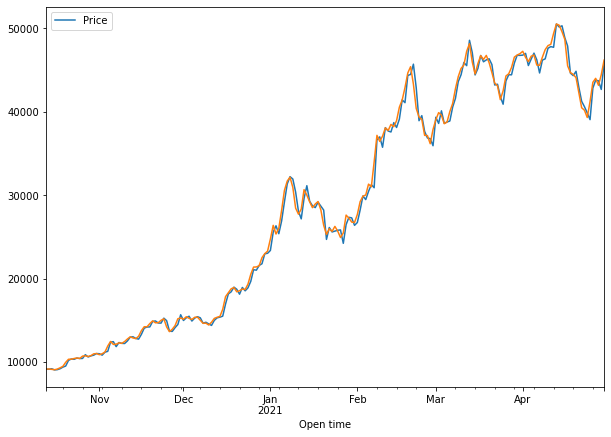

Predict score: 99.69


In [11]:
X = mean_predict[['Open', 'High', 'Low', 'Close']]
y = mean_predict['next_day_price']

t = 0.8
t = int(t*len(mean_predict))

X_train = X[:t]
y_train = y[:t]

X_test = X[t:]
y_test = y[t:]

model = LinearRegression()
model.fit(X_train, y_train)

predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])

predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.show()

score = model.score(X[t:], y[t:])*100
print(f"Predict score: {float(score.round(2))}" )

In [12]:
mean_predict = historical_price.copy()

mean_predict = mean_predict.iloc[:,0:4]
mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict = mean_predict.dropna()
mean_predict['predicted_crypto_price'] = model.predict(mean_predict[['Open', 'High', 'Low', 'Close']])
mean_predict.tail()

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,predicted_crypto_price
Open time,,,,,,
2021-04-27,54001.38,55460.00,53222.00,55011.97,54423.8375,43794.744560
2021-04-28,55011.97,56428.00,53813.16,54846.22,55024.8375,43727.597812
2021-04-29,54846.23,55195.84,52330.94,53555.00,53982.0025,42685.998183
2021-04-30,53555.00,57963.00,53013.01,57694.27,55556.3200,45808.301904
2021-05-01,57697.25,58458.07,57116.16,57763.57,57758.7625,46043.035110


In [13]:
close_predict.tail()

,Open,High,Low,Close,Volume,close_3,close_9,predicted_crypto_price
Open time,,,,,,,,
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675,52693.376667,52976.648889,52290.312512
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015,54619.860000,52889.213333,54680.751134
2021-04-29,54846.23,55195.84,52330.94,53555.00,52486.019455,54471.063333,52570.324444,54573.548018
2021-04-30,53555.00,57963.00,53013.01,57694.27,68578.910045,55365.163333,53004.395556,55570.116054
2021-05-01,57697.25,58458.07,57116.16,57763.57,23213.310223,56337.613333,53679.130000,56605.834852


In [14]:
mean_predict['move'] = np.where(
    mean_predict['predicted_crypto_price'].shift(1) < mean_predict['predicted_crypto_price'], "Buy", "Stay"
)
mean_predict.tail()

,Open,High,Low,Close,mean,predicted_crypto_price,move
Open time,,,,,,,
2021-04-27,54001.38,55460.00,53222.00,55011.97,54423.8375,43794.744560,Buy
2021-04-28,55011.97,56428.00,53813.16,54846.22,55024.8375,43727.597812,Stay
2021-04-29,54846.23,55195.84,52330.94,53555.00,53982.0025,42685.998183,Stay
2021-04-30,53555.00,57963.00,53013.01,57694.27,55556.3200,45808.301904,Buy
2021-05-01,57697.25,58458.07,57116.16,57763.57,57758.7625,46043.035110,Buy


In [15]:
money = 10 
money_spend = 0
buys = 0
buyed_coins = 0
for i in range(len(mean_predict)):
    if mean_predict['move'].iloc[i] == 'Buy':
        buys +=1
        buyed_coins += money / mean_predict['mean'].iloc[i]
        money_spend += money


coin_price = mean_predict['mean'].iloc[-1]

print(f"Buys number: {buys}\nBuyed coins: {buyed_coins}\nMoney spend: {money_spend}\nCurrent coin price: {coin_price}")
print()
fortune = buyed_coins*coin_price
print(f'Fortune: {fortune.round(2)}\nProfit: {(fortune-money_spend).round(2)}')

Buys number: 543
Buyed coins: 0.6732396290789668
Money spend: 5430
Current coin price: 57758.762500000004

Fortune: 38885.49
Profit: 33455.49


In [16]:
money = 10
money_spend = 0
buys = 0
sales = 0
buyed_coins = 0
for i in range(len(mean_predict)):
    if mean_predict['move'].iloc[i] == 'Buy':
        buys +=1
        buyed_coins += money / mean_predict['mean'].iloc[i]
        money_spend += money
    else:
        sales +=1
        buyed_coins -= money / mean_predict['mean'].iloc[i]
        money_spend -= money 

coin_price = mean_predict['mean'].iloc[-1]

print(f"Buys number: {buys}\nSales numebr: {sales}\nBuyed coins: {buyed_coins}\nMoney spend: {money_spend}\nCurrent coin price: {coin_price}")
print()
fortune = buyed_coins*coin_price
print(f'Fortune: {fortune.round(2)}\nProfit: {(fortune-money_spend).round(2)}')

Buys number: 543
Sales numebr: 457
Buyed coins: 0.09624519300574298
Money spend: 860
Current coin price: 57758.762500000004

Fortune: 5559.0
Profit: 4699.0
